One or the properties of 'Deep Learning' is that it is able to generate higher level features within the neural network and then use these features to build the predictios for the model. Seeing as we have to use Gumboot machine learning for this challenge we'll go all old-school and use something that has some similar properites.

We have $#*&-all data so it doesn't make sense to try throwing the raw array at the superrvised learning model becasue we'll just overfit. Instead, in the approach below we use [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) as a sort of unsupervised feature extractor to reduce the dimensionality of the data. Then we'll train a Support Vector Machine with Radial Basis Function kernel (and yes, an RBF kernel means it's non-parametric!) on the eigenvectors as a supervised model. 

This is based on the tutorial [here](http://www.scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html).

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
import numpy as np
from PIL import Image, ImageOps, ImageChops
import cv2
import os
import pickle

#Inline Matplot graphics into the notebook
%matplotlib inline 


# From: https://gist.github.com/fabeat/6621507
# Using the version in the comments to the Gist
# Best practice default is using Bicubic rather than Antialias per http://pillow.readthedocs.io/en/3.0.x/releasenotes/2.7.0.html#default-filter-for-thumbnails
def scale(image, max_size=(128,128), method=Image.BICUBIC):
    """
    resize 'image' to 'max_size' keeping the aspect ratio
    and place it in center of white 'max_size' image
    """
    image.thumbnail(max_size, method)
    offset = (int((max_size[0] - image.size[0]) // 2), int((max_size[1] - image.size[1]) // 2))
    back = Image.new("RGB", max_size, "white")
    back.paste(image, offset)

    return back




 Volume in drive C has no label.
 Volume Serial Number is FA0E-62DB

 Directory of C:\git\mlopenhack\notebooks

08/01/2019  13:11    <DIR>          .
08/01/2019  13:11    <DIR>          ..
08/01/2019  13:09    <DIR>          .ipynb_checkpoints
08/01/2019  13:06             6,808 Challenge 0.ipynb
08/01/2019  13:06            42,298 Challenge 1.ipynb
08/01/2019  13:06           473,122 Challenge2.ipynb
08/01/2019  13:11           795,477 Challenge3.ipynb
08/01/2019  13:06           305,488 Challenge5.ipynb
               5 File(s)      1,623,193 bytes
               3 Dir(s)  20,491,190,272 bytes free


In [3]:
gear_images_dir = "gear_images"
data = list()
labels = list()
images = list()
for directory in os.listdir(gear_images_dir):
    current_dir = gear_images_dir + '/' + directory
    print('Loading images from: {}'.format(current_dir))
    for imgName in os.listdir(os.fsencode(current_dir)):
        print('Loading: {}'.format(os.fsdecode(imgName)))
        image = Image.open(current_dir + '/' + os.fsdecode(imgName)) #Open as greyscale
        image = ImageOps.equalize(scale(image))
        images.append(image.convert('LA'))
        data.append(np.asarray(image.convert('L')).flatten())
        labels.append(directory)
    print('Done')   

Loading images from: gear_images/axes
Loading: 100172.jpeg
Loading: 10036053x1012980_zm.jpeg
Loading: 10045714_zm.jpeg
Loading: 100937.jpeg
Loading: 100938.jpeg
Loading: 10101173x1012980_zm.jpeg
Loading: 10188438x1011898_zm.jpeg
Loading: 10189964_zm.jpeg
Loading: 10189970_zm.jpeg
Loading: 10189971_zm.jpeg
Loading: 10215531x1028317_zm.jpeg
Loading: 10258915x1152209_zm.jpeg
Loading: 10260981_zm.jpeg
Loading: 10260983_zm.jpeg
Loading: 10285571x1013345_zm.jpeg
Loading: 10285573x1013345_zm.jpeg
Loading: 10291030_zm.jpeg
Loading: 10291102_zm.jpeg
Loading: 10321075_zm.jpeg
Loading: 10331860x1078795_zm.jpeg
Loading: 10331871x1010938_zm.jpeg
Loading: 10347141x1152209_zm.jpeg
Loading: 10351594_zm.jpeg
Loading: 10351595_zm.jpeg
Loading: 10351608_zm.jpeg
Loading: 10353611_zm.jpeg
Loading: 10353612_zm.jpeg
Loading: 10353624_zm.jpeg
Loading: 10353625_zm.jpeg
Loading: 107254.jpeg
Loading: 113409.jpeg
Loading: 113410.jpeg
Loading: 1312778_000_main.jpg
Loading: 1312779_000_main.jpg
Loading: 1312786_004

Loading: 10337557x1037283_zm.jpeg
Loading: 10337559_zm.jpeg
Loading: 10337566x1010913_zm.jpeg
Loading: 10337571_zm.jpeg
Loading: 10337574_zm.jpeg
Loading: 10337575_zm.jpeg
Loading: 10337577x1010913_zm.jpeg
Loading: 10337577x1011898_zm.jpeg
Loading: 10337577x1036824_zm.jpeg
Loading: 10337577x1036933_zm.jpeg
Loading: 10337577x1037283_zm.jpeg
Loading: 10338927_zm.jpeg
Loading: 10338928_zm.jpeg
Loading: 10338929_zm.jpeg
Loading: 10338931_zm.jpeg
Loading: 10338932_zm.jpeg
Loading: 10338933_zm.jpeg
Loading: 10338934x1012905_zm.jpeg
Loading: 10338934x1013041_zm.jpeg
Loading: 10353615x1012163_zm.jpeg
Loading: 10357852x1010913_zm.jpeg
Loading: 10357852x1011898_zm.jpeg
Loading: 10357852x1012549_zm.jpeg
Loading: 10364087x1012163_zm.jpeg
Loading: 10364087x1012905_zm.jpeg
Loading: 10364087x1049516_zm.jpeg
Loading: 10364088x1012549_zm.jpeg
Loading: 10364089_zm.jpeg
Loading: 10364090x1010913_zm.jpeg
Loading: 10364090x1012549_zm.jpeg
Loading: 10364090x1024698_zm.jpeg
Loading: 10364090x1164843_zm.jpeg


Loading: 10344806x1050984_zm.jpeg
Loading: 10344806x1150363_zm.jpeg
Loading: 10345378x1012905_zm.jpeg
Loading: 10345378x1141723_zm.jpeg
Loading: 10345414x1012905_zm.jpeg
Loading: 10345415x1012905_zm.jpeg
Loading: 10345467x1012905_zm.jpeg
Loading: 10345467x1040231_zm.jpeg
Loading: 10345868x1050984_zm.jpeg
Loading: 10345871x1050984_zm.jpeg
Loading: 10346332x1050984_zm.jpeg
Loading: 10347142x1011017_zm.jpeg
Loading: 10347165x1010953_zm.jpeg
Loading: 10347387x1012905_zm.jpeg
Loading: 10347452x1012905_zm.jpeg
Loading: 10349537x1012905_zm.jpeg
Loading: 10350471x1012905_zm.jpeg
Loading: 10352662x1012905_zm.jpeg
Loading: 10352662x1060130_zm.jpeg
Loading: 10352662x1157585_zm.jpeg
Loading: 10352662x1157593_zm.jpeg
Loading: 10352662x1168865_zm.jpeg
Loading: 10353141x1012163_zm.jpeg
Loading: 10353141x1012905_zm.jpeg
Loading: 10353143x1012163_zm.jpeg
Loading: 10355642x1012905_zm.jpeg
Loading: 10374235x1169490_zm.jpeg
Loading: 10374241x1012905_zm.jpeg
Loading: 10374242x1012905_zm.jpeg
Loading: 10374

Loading: 10305872x1013634_zm.jpeg
Loading: 10312590x1012905_zm.jpeg
Loading: 10312590x1044494_zm.jpeg
Loading: 10312590x1149778_zm.jpeg
Loading: 10312717x1012905_zm.jpeg
Loading: 10312717x1044494_zm.jpeg
Loading: 10313191x1012905_zm.jpeg
Loading: 10313191x1121354_zm.jpeg
Loading: 10313191x1128654_zm.jpeg
Loading: 10313297x1012425_zm.jpeg
Loading: 10313297x1012905_zm.jpeg
Loading: 10313297x1149124_zm.jpeg
Loading: 10313298x1037114_zm.jpeg
Loading: 10313298x1120209_zm.jpeg
Loading: 10313301x1011296_zm.jpeg
Loading: 10313301x1012798_zm.jpeg
Loading: 10313301x1012905_zm.jpeg
Loading: 10313301x1118348_zm.jpeg
Loading: 10313301x1140544_zm.jpeg
Loading: 10313302x1012798_zm.jpeg
Loading: 10313302x1030283_zm.jpeg
Loading: 10313302x1120209_zm.jpeg
Loading: 10313302x1128790_zm.jpeg
Loading: 10313318x1011296_zm.jpeg
Loading: 10313318x1012905_zm.jpeg
Loading: 10313318x1063463_zm.jpeg
Loading: 10313318x1140544_zm.jpeg
Loading: 10313319x1035919_zm.jpeg
Loading: 10313319x1128689_zm.jpeg
Loading: 10313

Loading: 10341911_zm.jpeg
Loading: 10347173x1011463_zm.jpeg
Loading: 10347174x1055935_zm.jpeg
Loading: 10373797_zm.jpeg
Loading: 10373800_zm.jpeg
Loading: 10373801_zm.jpeg
Loading: 10373820_zm.jpeg
Loading: 10373870_zm.jpeg
Loading: 10373976_zm.jpeg
Loading: 10373982_zm.jpeg
Loading: 10373988_zm.jpeg
Loading: 10374001_zm.jpeg
Loading: 10374002_zm.jpeg
Loading: 10374015_zm.jpeg
Loading: 10374019x1012138_zm.jpeg
Loading: 10374050_zm.jpeg
Loading: 107257.jpeg
Loading: 107259.jpeg
Loading: 107313.jpeg
Loading: 109940.jpeg
Loading: 111236.jpeg
Loading: 113913.jpeg
Loading: 113914.jpeg
Loading: 113916.jpeg
Loading: 114690.png
Loading: 117703.png
Loading: 122225.jpeg
Loading: 122226.jpeg
Loading: 122728.png
Loading: 1313485_408_main.png
Loading: 1313563_408_main.jpg
Loading: 1313564_801_main.jpg
Loading: 1313569_408_main.jpg
Loading: 1313570_004_main.jpg
Loading: 1313571_408_main.jpg
Loading: 1313574_601_main.jpg
Loading: 2002872_001_main.jpg
Loading: 2008772_004_main.jpeg
Loading: 2008777_91

Loading: 10317138x1050984_zm.jpeg
Loading: 10317138x1058135_zm.jpeg
Loading: 10317138x1122008_zm.jpeg
Loading: 10317138x1150445_zm.jpeg
Loading: 10342601x1010953_zm.jpeg
Loading: 10342601x1012360_zm.jpeg
Loading: 10342601x1012905_zm.jpeg
Loading: 10342601x1140536_zm.jpeg
Loading: 10342601x1140544_zm.jpeg
Loading: 10342602x1012905_zm.jpeg
Loading: 10342602x1044830_zm.jpeg
Loading: 10342602x1069414_zm.jpeg
Loading: 10342602x1086248_zm.jpeg
Loading: 10342602x1128689_zm.jpeg
Loading: 10342603x1011296_zm.jpeg
Loading: 10342603x1012905_zm.jpeg
Loading: 10342603x1063468_zm.jpeg
Loading: 10342603x1149124_zm.jpeg
Loading: 10342607x1011296_zm.jpeg
Loading: 10342607x1012360_zm.jpeg
Loading: 10342607x1012905_zm.jpeg
Loading: 10342607x1149124_zm.jpeg
Loading: 10342608x1011875_zm.jpeg
Loading: 10342608x1061637_zm.jpeg
Loading: 10342608x1128689_zm.jpeg
Loading: 10343658x1012905_zm.jpeg
Loading: 10343658x1042652_zm.jpeg
Loading: 10343658x1108394_zm.jpeg
Loading: 10343658x1149670_zm.jpeg
Loading: 10343

Loading: 10333522_zm.jpeg
Loading: 10333583x1041689_zm.jpeg
Loading: 10333583x1043973_zm.jpeg
Loading: 10334655x1011898_zm.jpeg
Loading: 10334706x1011898_zm.jpeg
Loading: 10334708x1011898_zm.jpeg
Loading: 10334717x1011898_zm.jpeg
Loading: 10346183_zm.jpeg
Loading: 10368482_zm.jpeg
Loading: 10368522_zm.jpeg
Loading: 117562.jpeg
Loading: 2019036_331_main.jpg
Loading: 2022205_701_main.jpg
Loading: 2022267_308_main.jpg
Loading: 2022268_308_main.jpg
Loading: 2022270_308_main.jpg
Loading: 2022271_308_main.jpg
Loading: 2022272_308_main.jpg
Loading: 2022274_308_main.jpg
Loading: 2022525_101_main.jpg
Loading: 2022530_004_main.jpg
Loading: 2022534_101_main.jpg
Loading: 2023997_805_main.jpg
Loading: 2023998_805_main.jpg
Loading: 2023999_805_main.jpg
Loading: 2024001_805_main.jpg
Loading: 2030132_805_main.jpg
Loading: 2030140_004_main.jpg
Loading: 2030142_004_main.jpg
Loading: 2030147_707_main.jpg
Loading: 2030148_602_main.jpg
Loading: 2030149_602_main.jpg
Loading: 2030167_707_main.jpg
Loading: 20

In [4]:
data_array = np.asarray(data)
print(data_array.shape)

label_array = np.asarray(labels)
print(label_array.shape)

labels.sort()

(2122, 16384)
(2122,)


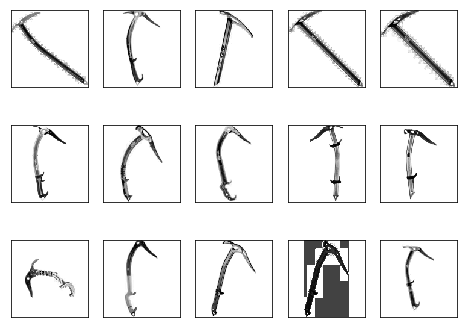

In [5]:
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i], cmap=plt.cm.bone)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_array/ 255,
        label_array, random_state=0)

print(X_train.shape, X_test.shape)

(1591, 16384) (531, 16384)


Decompose into the first 150 principal components.

In [7]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)
pickle.dump(pca, open( "pca.p", "wb" ) )
file = open("pca.p",'rb')
pca = pickle.load(file)

We can draw the 'average' image.

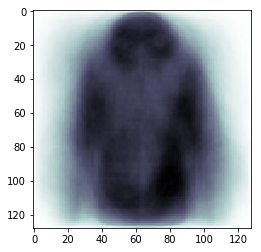

In [153]:
plt.imshow(pca.mean_.reshape(np.asarray(images[0].convert('L')).shape),
           cmap=plt.cm.bone)

We can visualize the principal components

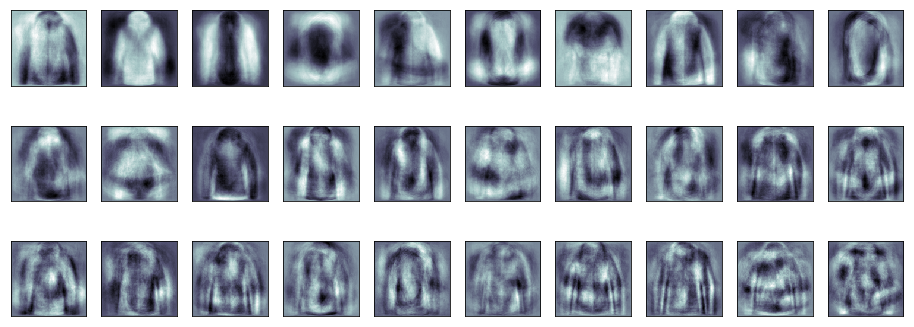

In [154]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(np.asarray(images[0].convert('L')).shape),
              cmap=plt.cm.bone)

In [155]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(1591, 150)
(531, 150)


Now we can fit an SVM with RBF kernel to the data.

In [156]:
from sklearn import svm
clf = svm.SVC(C=5., kernel='rbf', gamma=0.001)
clf.fit(X_train_pca, y_train)
pickle.dump(clf, open( "svm.p", "wb" ) )

The model does a reasonable job of predicting outcomes. It will not be particularly robust to scale and rotational transforms but it's pretty impressive for such a simple model.

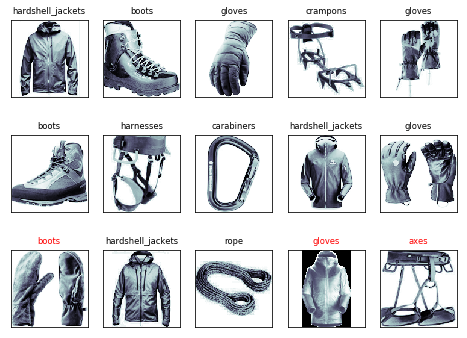

In [157]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(np.asarray(images[0].convert('L')).shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred,
                 fontsize='small', color=color)

In [9]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

NameError: name 'clf' is not defined

In [10]:
import itertools
# Pretty print CM from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#pint(metrics.confusion_matrix(y_test, y_pred))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

cm_labels = list(set(labels))
cm_labels.sort()

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                      title='Confusion matrix')

NameError: name 'y_pred' is not defined

Let's train SVM on the big data... 

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(label_array)

LabelEncoder()

In [12]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
clf = classifier.fit(X_train, le.transform(y_train))
from sklearn import metrics
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, le.inverse_transform(y_pred)))

                   precision    recall  f1-score   support

             axes       0.75      0.64      0.69        28
            boots       0.69      0.82      0.75        22
       carabiners       0.76      0.81      0.78        63
         crampons       0.81      0.68      0.74        38
           gloves       0.53      0.63      0.58        51
hardshell_jackets       0.74      0.81      0.77       106
        harnesses       0.80      0.80      0.80        45
          helmets       0.83      0.62      0.71        24
insulated_jackets       0.61      0.50      0.55        68
          pulleys       0.42      0.36      0.38        14
             rope       0.62      0.65      0.64        43
            tents       0.83      0.86      0.85        29

      avg / total       0.71      0.70      0.70       531



c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


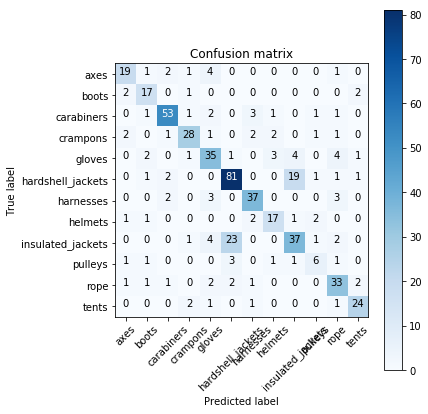

In [80]:

cnf_matrix = metrics.confusion_matrix(y_test, le.inverse_transform(y_pred))
np.set_printoptions(precision=2)

cm_labels = list(set(labels))
cm_labels.sort()

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                      title='Confusion matrix')

In [13]:
from random import uniform
from pipe import take, select, as_list, Pipe

import random
@Pipe
def pshuffle(l):
    random.shuffle(l)
    return l


def noiseImages( images ):
    images_whitenoise = images / 255

    mask = images_whitenoise>0.95
    vals = range(np.count_nonzero(mask)) | select( lambda n: uniform(0, 1)) | as_list()

    # Assign back into X
    images_whitenoise[mask] = vals
    return images_whitenoise
    
    
X_test_whitenoise = noiseImages( X_test )
X_train_whitenoise = noiseImages( X_train )

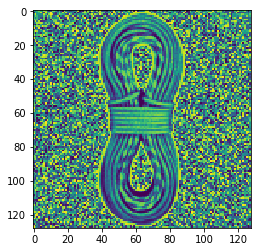

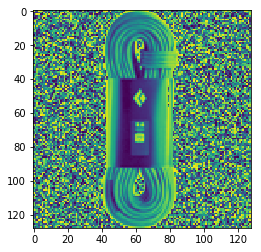

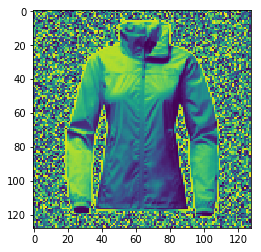

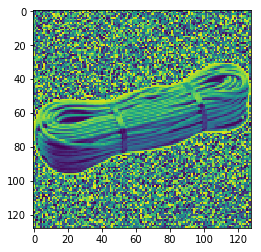

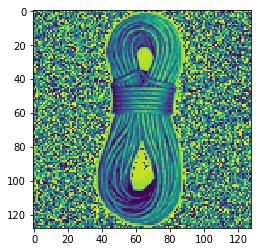

In [145]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

noisy_images = range( X_test_whitenoise.shape[0] )     \
    | as_list()     \
    | pshuffle()     \
    | take(5)     \
    | select( lambda i: X_test_whitenoise[i] )     \
    | as_list()

for img in noisy_images:

    plt.imshow(img.reshape(128,128))
    plt.show()

ID3 on noisy images

In [235]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
clf = classifier.fit(X_train_whitenoise, le.transform(y_train))
from sklearn import metrics
y_pred = clf.predict(X_test_whitenoise)
print(metrics.classification_report(y_test, le.inverse_transform(y_pred)))

                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        28
            boots       0.21      0.27      0.24        22
       carabiners       0.13      0.13      0.13        63
         crampons       0.14      0.08      0.10        38
           gloves       0.24      0.37      0.29        51
hardshell_jackets       0.48      0.47      0.48       106
        harnesses       0.16      0.13      0.14        45
          helmets       0.10      0.12      0.11        24
insulated_jackets       0.37      0.34      0.35        68
          pulleys       0.00      0.00      0.00        14
             rope       0.33      0.37      0.35        43
            tents       0.11      0.14      0.12        29

      avg / total       0.25      0.26      0.25       531



c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


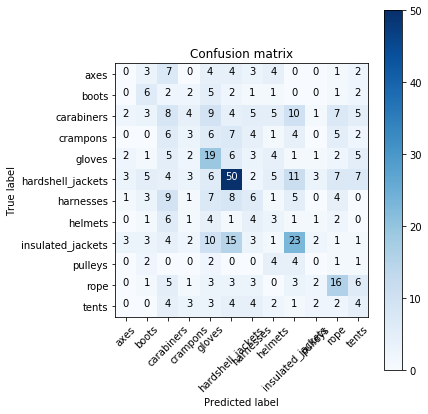

In [236]:
cnf_matrix = metrics.confusion_matrix(y_test, le.inverse_transform(y_pred))
np.set_printoptions(precision=2)

cm_labels = list(set(labels))
cm_labels.sort()

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                      title='Confusion matrix')

In [237]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train_whitenoise)
pickle.dump(pca, open( "pca.p", "wb" ) )
file = open("pca.p",'rb')
pca = pickle.load(file)

In [162]:
from sklearn import metrics
X_test_pca_noise = pca.transform(X_test_whitenoise)
X_train_pca_noise = pca.transform(X_train_whitenoise)

clf = svm.SVC(C=5., kernel='rbf', gamma=0.001)
clf.fit(X_train_pca_noise, y_train)
pickle.dump(clf, open( "svm.p", "wb" ) )

y_pred = clf.predict(X_test_pca_noise)
print(metrics.classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        28
            boots       0.67      0.64      0.65        22
       carabiners       0.40      0.92      0.56        63
         crampons       0.64      0.37      0.47        38
           gloves       0.58      0.55      0.57        51
hardshell_jackets       0.66      0.86      0.75       106
        harnesses       0.73      0.42      0.54        45
          helmets       0.72      0.54      0.62        24
insulated_jackets       0.89      0.59      0.71        68
          pulleys       1.00      0.07      0.13        14
             rope       0.65      0.77      0.70        43
            tents       0.93      0.48      0.64        29

      avg / total       0.65      0.61      0.59       531



c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


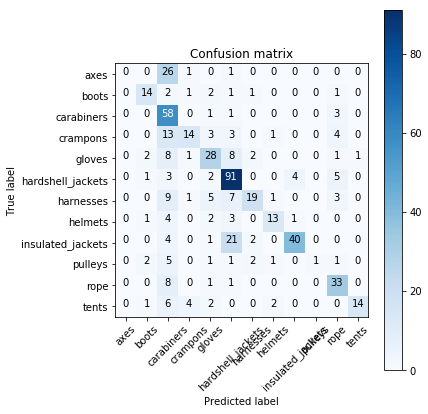

In [163]:

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

cm_labels = list(set(labels))
cm_labels.sort()

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                      title='Confusion matrix')

(array([ 21., 146.,  22.,  48., 138.,   0.,  26.,  18.,  45.,   1.,  51.,
         15.]),
 array([ 1.  ,  1.83,  2.67,  3.5 ,  4.33,  5.17,  6.  ,  6.83,  7.67,
         8.5 ,  9.33, 10.17, 11.  ]),
 <a list of 12 Patch objects>)

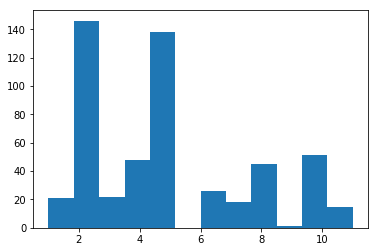

In [164]:
plt.hist(le.transform(y_pred), bins=12)

In [14]:
from pipe import chain, as_dict, Pipe, select, take, as_list

@Pipe
def pcycle(iterable):
    while True:
        for it in iterable:
            yield it
        
@Pipe
def as_npy(iterable):
    return np.array(iterable)

def balancedSignalGenerator(X,y,num_classes=10):
    
    class_map = {}
    for c in range(num_classes):
        class_map[c] = list(np.where( y==c)[0])
                            
    D = range(num_classes) \
        | select( lambda c: class_map[c] | pcycle | select( lambda i: (c,X[i]) )  ) \
        | as_list

    while True:
        for c in D:
            yield next(c)[0], next(c)[1]

        
data = balancedSignalGenerator(X_train_whitenoise,le.transform(y_train)) | take(1000) | as_list

Xbal = data | select(lambda el: el[1])  | as_list | as_npy
ybal = data | select(lambda el: el[0])  | as_list | as_npy

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

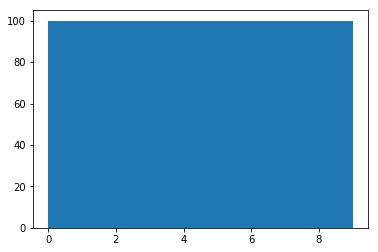

In [239]:
plt.hist(ybal,bins=10)

In [247]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
clf = classifier.fit(Xbal, ybal)
from sklearn import metrics
y_pred = clf.predict(X_test_pca_noise)
print(metrics.classification_report(y_test, le.inverse_transform(y_pred)))

                   precision    recall  f1-score   support

             axes       0.56      0.64      0.60        28
            boots       0.23      0.41      0.30        22
       carabiners       0.31      0.48      0.38        63
         crampons       0.42      0.39      0.41        38
           gloves       0.33      0.37      0.35        51
hardshell_jackets       0.56      0.44      0.49       106
        harnesses       0.38      0.40      0.39        45
          helmets       0.33      0.62      0.43        24
insulated_jackets       0.53      0.62      0.57        68
          pulleys       0.21      0.21      0.21        14
             rope       0.00      0.00      0.00        43
            tents       0.00      0.00      0.00        29

      avg / total       0.37      0.41      0.38       531



c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [250]:
clf = svm.SVC(C=5., kernel='rbf', gamma=0.001)
clf.fit(Xbal, ybal)
pickle.dump(clf, open( "svm.p", "wb" ) )
y_pred = clf.predict(X_test_pca_noise)
print(metrics.classification_report(y_test, le.inverse_transform(y_pred)))

                   precision    recall  f1-score   support

             axes       0.23      0.75      0.35        28
            boots       0.45      0.68      0.55        22
       carabiners       0.41      0.68      0.51        63
         crampons       0.47      0.50      0.49        38
           gloves       0.53      0.47      0.50        51
hardshell_jackets       0.84      0.68      0.75       106
        harnesses       0.72      0.47      0.57        45
          helmets       0.56      0.62      0.59        24
insulated_jackets       0.71      0.71      0.71        68
          pulleys       0.43      0.21      0.29        14
             rope       0.00      0.00      0.00        43
            tents       0.00      0.00      0.00        29

      avg / total       0.52      0.53      0.51       531



c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


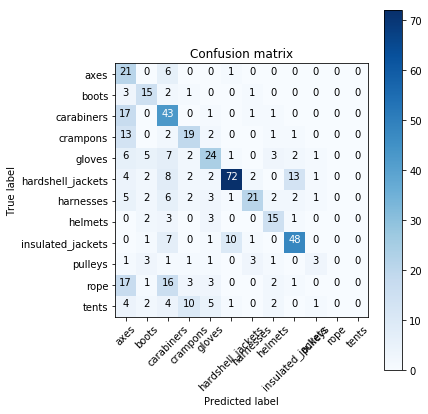

In [254]:
cnf_matrix = metrics.confusion_matrix(y_test, le.inverse_transform(y_pred))
np.set_printoptions(precision=2)

cm_labels = list(set(labels))
cm_labels.sort()

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                      title='Confusion matrix')

In [15]:
from keras.utils import to_categorical

Xbal = Xbal.reshape(1000,128,128,1)
Yone = to_categorical(ybal)
ValXSquare = X_test_whitenoise.reshape(531,128,128,1)

In [273]:
Yone.shape

(1000, 10)

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
model.fit(Xbal, Yone, epochs=3)

#validation_data=(ValXSquare, to_categorical(le.transform(y_test)))

Using TensorFlow backend.


NameError: name 'Xbal' is not defined